## Import Required Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, f1_score, 
                             precision_recall_curve, roc_curve, auc,
                             confusion_matrix, PrecisionRecallDisplay)
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.calibration import calibration_curve


## Configure visualizations

In [ ]:
# Configure visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data & Feature Engineering

In [21]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['cpu_usage', 'cpu_limit', 'memory_usage', 'memory_limit', 'restart_count']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Derived features
    df['cpu_utilization'] = df['cpu_usage'] / df['cpu_limit']
    df['memory_utilization'] = df['memory_usage'] / df['memory_limit']
    df['cpu_request_diff'] = df['cpu_usage'] - df['cpu_request']
    df['memory_request_diff'] = df['memory_usage'] - df['memory_request']
    df['cpu_request_ratio'] = df['cpu_request'] / df['cpu_limit']
    df['cpu_mem_interaction'] = df['cpu_usage'] * df['memory_usage']

    # Rolling Statistics with No Data Leakage
    window_size = 7
    for col in ['cpu_usage', 'memory_usage']:
        df[f'{col}_var'] = df[col].shift(1).rolling(window_size, min_periods=1).var()
        df[f'{col}_ema'] = df[col].shift(1).ewm(span=5).mean()
        df[f'{col}_min'] = df[col].shift(1).rolling(window_size, min_periods=1).min()
        df[f'{col}_max'] = df[col].shift(1).rolling(window_size, min_periods=1).max()

    # Lag Features
    df['cpu_usage_lag1'] = df['cpu_usage'].shift(1)
    df['memory_usage_lag1'] = df['memory_usage'].shift(1)

    return df


## Data Preprocessing

In [29]:
def preprocess_data(df_split):
    window_size = 7
    processed = df_split.copy()
    for metric in ['cpu', 'memory']:
        processed[f'{metric}_ma'] = processed[f'{metric}_usage'].shift(1).rolling(window_size, min_periods=1).mean()
        processed[f'{metric}_std'] = processed[f'{metric}_usage'].shift(1).rolling(window_size, min_periods=1).std()
    processed['cpu_anomaly'] = (processed['cpu_usage'] > (processed['cpu_ma'] + 1.5 * processed['cpu_std'])).astype(int)
    processed['memory_anomaly'] = (processed['memory_usage'] > (processed['memory_ma'] + 1.5 * processed['memory_std'])).astype(int)
    return processed.dropna()


features = [
    'cpu_usage', 'memory_usage', 'cpu_utilization', 'memory_utilization',
    'cpu_request_diff', 'memory_request_diff', 'restart_count',
    'cpu_limit', 'memory_limit', 'cpu_mem_interaction', 'cpu_request_ratio',
    'cpu_usage_var', 'memory_usage_var', 'cpu_usage_ema', 'memory_usage_ema',
    'cpu_usage_min', 'memory_usage_min', 'cpu_usage_max', 'memory_usage_max',
    'cpu_usage_lag1', 'memory_usage_lag1'
]
df = load_and_preprocess("kubernetes_resource_allocation_dataset.csv")
train_df = preprocess_data(df.iloc[:int(0.8*len(df))])
test_df = preprocess_data(df.iloc[int(0.8*len(df)):])


## Scaling

In [30]:
def scale_features(X, scaler=None, fit=False):
    if fit:
        scaler = StandardScaler().fit(X)
    scaled = scaler.transform(X)
    return pd.DataFrame(scaled, columns=X.columns), scaler

## Visualization

In [31]:
def plot_model_performance(y_true, y_pred, probs, threshold, target):
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Confusion Matrix
    ax = axes[0, 0]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f'{target} Confusion Matrix')
    
    # ROC Curve
    ax = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f'{target} ROC Curve')
    ax.legend()
    
    # Precision-Recall Curve
    ax = axes[1, 0]
    PrecisionRecallDisplay.from_predictions(y_true, probs, ax=ax)
    ax.set_title(f'{target} Precision-Recall Curve')
    
    # Calibration Curve
    ax = axes[1, 1]
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f'{target} Calibration Curve')
    
    plt.tight_layout()
    plt.show()


## Train and Evaluate

In [32]:
def train_and_evaluate_cpu_optimized(target='cpu_anomaly'):
    
    # Data preparation
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[target]
    y_test = test_df[target]

    # Robust scaling
    X_train_scaled, scaler = scale_features(X_train, fit=True)
    X_test_scaled, _ = scale_features(X_test, scaler)

    from sklearn.feature_selection import RFE
    selector = RFE(LGBMClassifier(n_estimators=50, verbosity=-1), n_features_to_select=15)
    # Stratified K-Fold with more splits
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Reduced to 5 for stability
    
    best_model = None
    best_precision = 0
    best_threshold = 0.5
    best_selector = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
        X_tr = X_train_scaled.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_val = X_train_scaled.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        # Feature selection per fold
        selector.fit(X_tr, y_tr)
        X_tr_sel = selector.transform(X_tr)
        X_val_sel = selector.transform(X_val)

        # Balanced SMOTE with adjusted ratio
        # Dynamic SMOTE ratio based on class imbalance
        # Safely calculate the SMOTE ratio with proper parentheses and error handling
        smote_ratio = min(1.0, ( (len(y_tr[y_tr==1]) / max(1, len(y_tr[y_tr==0])) ) + 0.3 ))
        smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)
        # = SMOTE(sampling_strategy=0.6, random_state=42)
        X_res, y_res = smote.fit_resample(X_tr_sel, y_tr)

        # Model with increased regularization
        base_models = [
            ('xgb', XGBClassifier(n_estimators=150, learning_rate=0.05,
                         max_depth=3, subsample=0.8, colsample_bytree=0.8,
                         scale_pos_weight=5,
                         eval_metric='logloss')),
            ('lgbm', LGBMClassifier(n_estimators=150, learning_rate=0.05,
                           max_depth=3, subsample=0.8, colsample_bytree=0.8,
                           class_weight={0:1, 1:5}, verbosity=-1))  # Added here
        ]
        
        meta_model = LogisticRegression(class_weight={0:1, 1:5}, max_iter=2000)
        
        model = StackingClassifier(base_models, final_estimator=meta_model)
        model.fit(X_res, y_res)
        
        # Fixed threshold optimization
        val_probs = model.predict_proba(X_val_sel)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
        
        viable_indices = [i for i, (p, r) in enumerate(zip(precision, recall)) 
                          if r > 0.80 or (r > 0.75 and p > 0.85)]  # More flexible recall targeting
        if not viable_indices:
            viable_indices = np.argsort(recall)[-5:]  # Fallback to top 5 recall values
        if viable_indices:
            best_idx = max(viable_indices, key=lambda i: precision[i])
            best_fold_threshold = thresholds[best_idx]
            fold_precision = precision[best_idx]
            
            if fold_precision > best_precision:
                best_precision = fold_precision
                best_model = clone(model)
                best_threshold = best_fold_threshold
                best_selector = clone(selector)

    # Final training if best model found
    if best_model is None:
        print("No viable threshold found with recall > 0.85")
        return None

    best_selector.fit(X_train_scaled, y_train)
    X_train_sel = best_selector.transform(X_train_scaled)
    X_test_sel = best_selector.transform(X_test_scaled)

    X_train_res, y_train_res = SMOTE(sampling_strategy=0.6, random_state=42).fit_resample(X_train_sel, y_train)
    best_model.fit(X_train_res, y_train_res)
    
    test_probs = best_model.predict_proba(X_test_sel)[:, 1]
    y_pred = (test_probs >= best_threshold).astype(int)

    print(classification_report(y_test, y_pred))
    plot_model_performance(y_test, y_pred, test_probs, best_threshold, f'{target} (Optimized)')

    return {
        'report': classification_report(y_test, y_pred),
        'best_threshold': best_threshold
    }


## Execution

=== Optimized CPU Anomaly Detection ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2724
           1       0.85      0.81      0.83       274

    accuracy                           0.97      2998
   macro avg       0.92      0.90      0.91      2998
weighted avg       0.97      0.97      0.97      2998



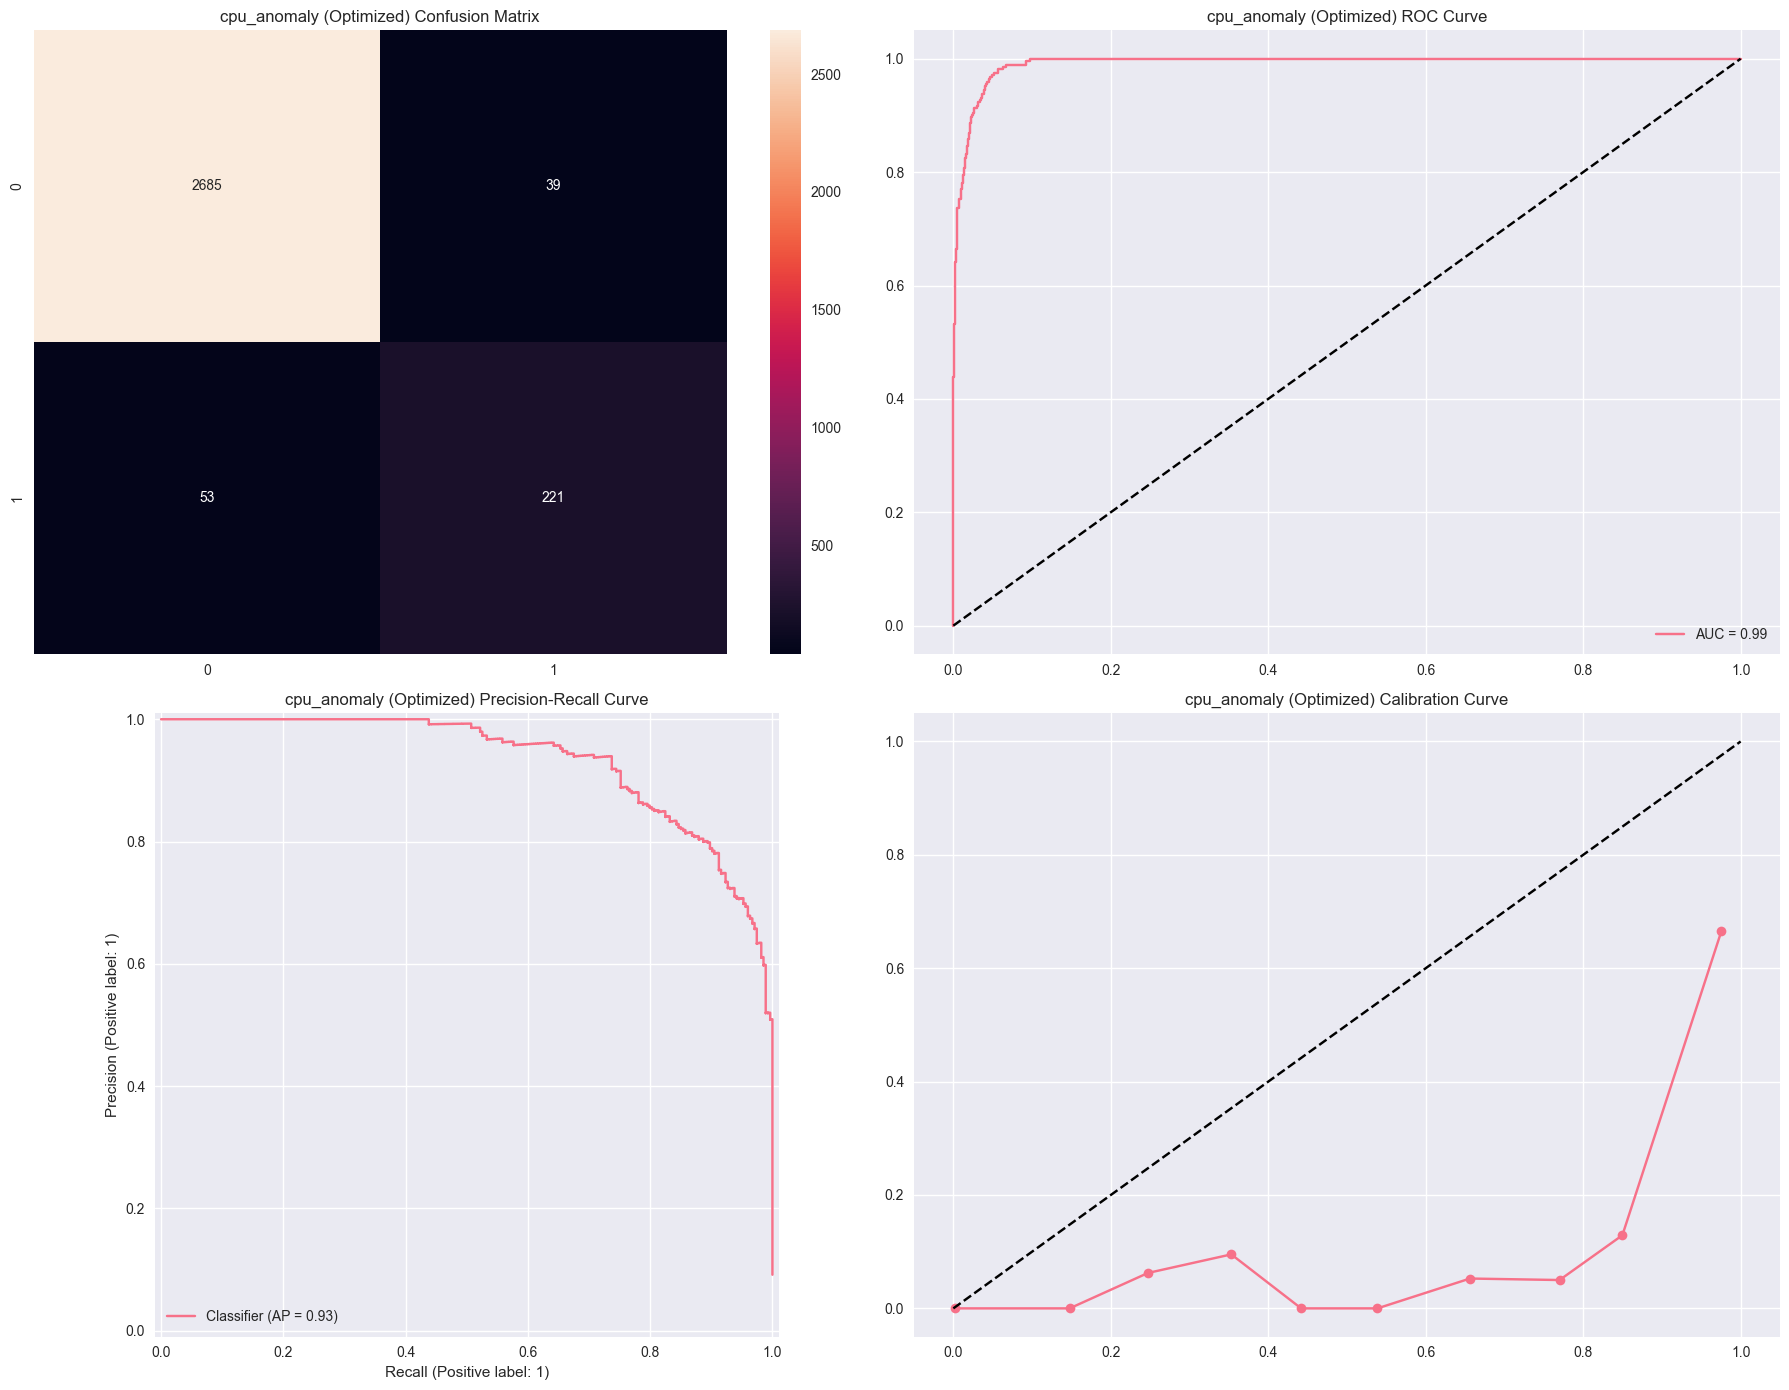


=== Optimized Memory Anomaly Detection ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2690
           1       0.88      0.76      0.82       308

    accuracy                           0.96      2998
   macro avg       0.93      0.87      0.90      2998
weighted avg       0.96      0.96      0.96      2998



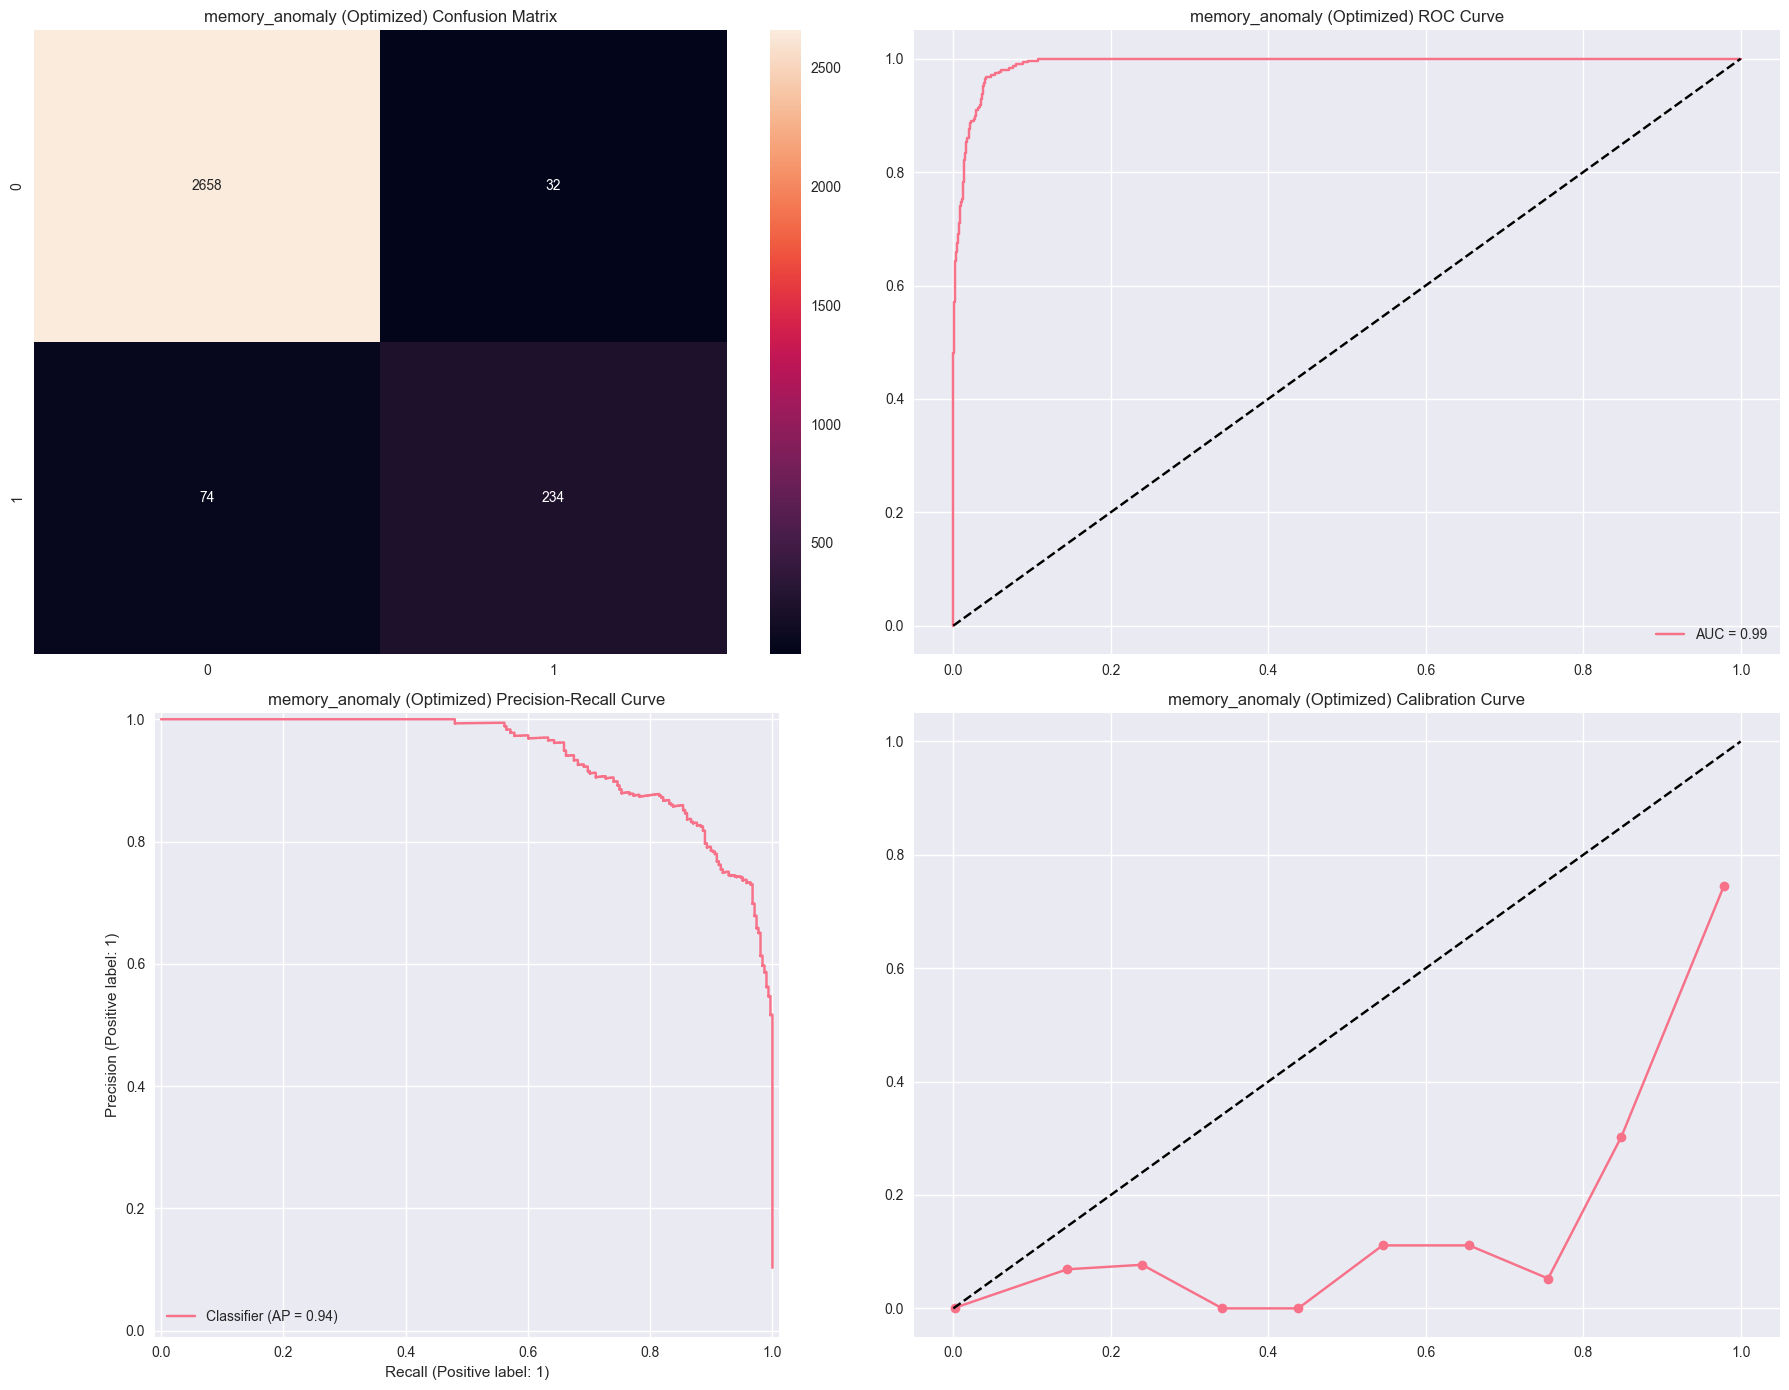

In [33]:


print("=== Optimized CPU Anomaly Detection ===")
optimized_cpu_results = train_and_evaluate_cpu_optimized('cpu_anomaly')

print("\n=== Optimized Memory Anomaly Detection ===")
optimized_memory_results = train_and_evaluate_cpu_optimized('memory_anomaly')